# Project: Wine Recommendation Generator 

### Team Members: Ivy Gooch, Areal Jones, Curt Lockhart

# Dataset

Ivy Gooch scraped the wine section of Drizly, thus creating a usable dataset with the following features:
- Title: Name of the wine
- Price: price (USD)
- Size: volume 
- Rating: a rating based on a scale of stars from 1-5 averaged
- Review Count: total number of reviews
- Category: type of wine
- Region: growing region
- ABV: alcohol by volume
- Body: characteristic to describe wine by its mouth feel
- Sweet-Dry Scale: if a wine is sweet or dry
- Tasting Notes: a description of the wine
- Food Pairing: what food complements the wine

# Imports Methods

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, learning_curve, ShuffleSplit
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Loading Wine Dataset

In [2]:
drizzly_csv = 'drizlyWinesCleaned.csv'
drizzly_df = pd.read_csv(drizzly_csv, sep=',')

In [3]:
drizzly_df.head()

,Title,Price,Size,Rating,Review Count,Category,Region,ABV,Body,Sweet-Dry Scale,Style,Tasting Notes,Food Pairing
0,Pomerol 1945,11862.00,750.0ml bottle,NaN,NaN,Merlot,"Bordeaux, France",NaN,Medium,Dry,Big & Bold,NaN,"Duck & Game Bird, Tomatoes"
1,Screaming Eagle Cabernet Sauvignon 2010,3372.00,1.5L bottle,NaN,NaN,Cabernet Sauvignon,"Napa Valley, United States",NaN,Full,Dry,Big & Bold,NaN,"Beef, Duck & Game Bird"
2,Romanee Conti Richebourg,1670.00,750.0ml bottle,NaN,NaN,Pinot Noir,NaN,NaN,Light,NaN,Fruity & Light,NaN,"Fish Meaty & Oily, Duck & Game Bird"
3,Chateau Palmer 1961,4000.00,750.0ml bottle,NaN,NaN,Bordeaux Blend,"Margaux, France",NaN,NaN,NaN,NaN,NaN,NaN
4,Krug Clos D'Ambonnay 1996,3999.99,750.0ml bottle,NaN,NaN,Champagne,"Champagne, France",NaN,NaN,NaN,NaN,NaN,NaN


# Cleaning the Data

In [4]:
drizzly_df.shape

(26253, 13)

#### Below removes any instance that has null values for either Category or Tasting Notes. 

In [5]:
new_drizzly_df = drizzly_df.dropna(axis=0, subset=['Category'])
new_drizzly_df = drizzly_df.dropna(axis=0, subset=['Tasting Notes'])
print(new_drizzly_df.shape)

(2311, 13)


#### Here let's replace the missing values of Body, Region, Style, Sweet-Dry Scale, and Food Pairing with a stop word. Replacing missing values with stop words will be filtered later. 

In [6]:
new_drizzly_df['Body'].fillna('a', inplace=True)
new_drizzly_df['Region'].fillna('a', inplace=True)
new_drizzly_df['Style'].fillna('a', inplace=True)
new_drizzly_df['Sweet-Dry Scale'].fillna('a', inplace=True)
new_drizzly_df['Food Pairing'].fillna('a', inplace=True)

#### Now, let's combine Body, Region, Style, Sweet-Dry Scale, and Food Pairing with Tasting Notes

In [7]:
new_drizzly_df['Tasting Notes'] = new_drizzly_df[['Body', 'Region','Sweet-Dry Scale', 'Style', 'Food Pairing', 'Tasting Notes']].agg(','.join, axis=1)
new_drizzly_df.head()

,Title,Price,Size,Rating,Review Count,Category,Region,ABV,Body,Sweet-Dry Scale,Style,Tasting Notes,Food Pairing
75,Biondi-Santi Brunello Di Montalcino DOCG Riserva,499.99,750.0ml bottle,NaN,NaN,Brunello,"Tuscany, Italy",0.14,a,Dry,Big & Bold,"a,Tuscany, Italy,Dry,Big & Bold,Beef, Cheese B...","Beef, Cheese Blue, Lamb"
83,Verite La Joie Sonoma County Red Blend,458.99,750.0ml bottle,NaN,NaN,Red Blend,"Sonoma County, United States",0.14,a,Dry,a,"a,Sonoma County, United States,Dry,a,Beef, Che...","Beef, Cheese Blue, Lamb, Mushrooms"
91,Piper Heidsieck Rare Rose,449.99,750.0ml bottle,NaN,NaN,Sparkling Rose Wine,"Champagne, France",0.12,a,Semi-Sweet / Off-Dry,a,"a,Champagne, France,Semi-Sweet / Off-Dry,a,Che...","Cheese Creamy & Bloomy, Cheese Fresh & Soft, C..."
117,Dal Forno Romano Amarone della Valpolicella DOCG,379.99,750.0ml bottle,NaN,NaN,Corvina,a,0.17,Medium,Dry,Big & Bold,"Medium,a,Dry,Big & Bold,Beef, Pasta,Bold, Cher...","Beef, Pasta"
120,Lokoya Spring Mountain Cabernet Sauvignon,378.10,750.0ml bottle,NaN,NaN,Cabernet Sauvignon,"Napa Valley, United States",0.15,Full,Dry,Big & Bold,"Full,Napa Valley, United States,Dry,Big & Bold...","Beef, Duck & Game Bird"


#### Lets drop the columns that we don't need including the region, body, sweet-dry scale, style, and food pairing that we combined with tasting notes.

In [8]:
final_drizzly_df = new_drizzly_df.drop(columns=['Rating', 'Review Count', 'Size','Title','Price','ABV','Body', 'Region','Sweet-Dry Scale', 'Style', 'Food Pairing'])
final_drizzly_df.head()

,Category,Tasting Notes
75,Brunello,"a,Tuscany, Italy,Dry,Big & Bold,Beef, Cheese B..."
83,Red Blend,"a,Sonoma County, United States,Dry,a,Beef, Che..."
91,Sparkling Rose Wine,"a,Champagne, France,Semi-Sweet / Off-Dry,a,Che..."
117,Corvina,"Medium,a,Dry,Big & Bold,Beef, Pasta,Bold, Cher..."
120,Cabernet Sauvignon,"Full,Napa Valley, United States,Dry,Big & Bold..."


# Reducing our number of Categories

#### The following is a graph of all of the categories of wine in our dataset.

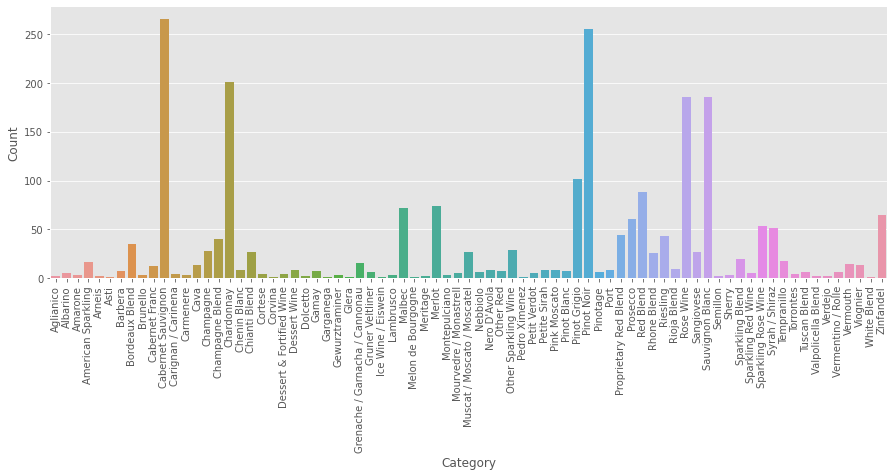

In [9]:
category_df = final_drizzly_df.groupby('Category')
categories = category_df['Category'].value_counts().index.tolist()
counts = category_df['Category'].value_counts()

count = []
category = []

for i in range(len(category_df['Category'].value_counts())):
    count.append(counts[i])
    category.append(categories[i][0])

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
plt.xticks(rotation=90)
counts_df = pd.DataFrame({'Category' : category, 'Count': count})
count_plot = sns.barplot(data= counts_df,x= 'Category',y= 'Count')

#### We are then creating a threshold so we can reduce the number of wine categories to below 15 (depending on how the classification goes) to create a more accurate prediction.

In [10]:
threshold = 90
wine_threshold_df = counts_df.drop(counts_df[counts_df.Count < threshold].index)
wine_threshold_df.shape

(6, 2)

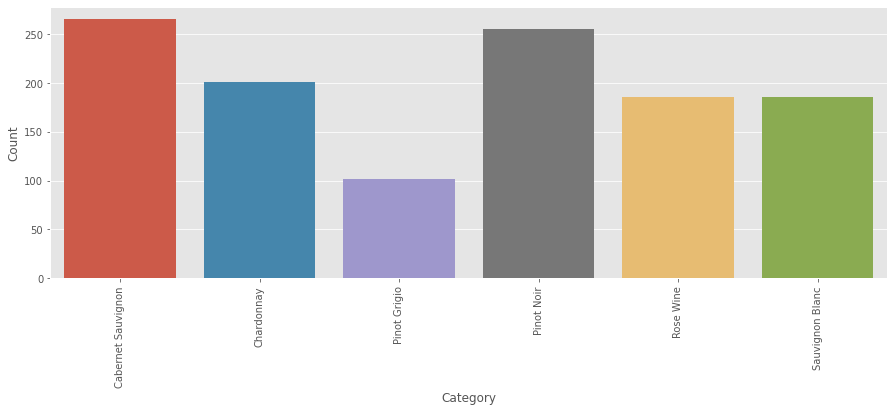

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
plt.xticks(rotation=90)
wine_threshold_plot = sns.barplot(data=wine_threshold_df,x= 'Category',y= 'Count')

#### We can then update our original dataframe to remove the instances of wine categories that we don't want.

In [12]:
categories_to_remove = [category for category in counts_df['Category'].unique() if category not in wine_threshold_df.Category.values]
new_final_drizzly_df = final_drizzly_df[~final_drizzly_df['Category'].isin(categories_to_remove)]
new_final_drizzly_df.head()

,Category,Tasting Notes
120,Cabernet Sauvignon,"Full,Napa Valley, United States,Dry,Big & Bold..."
121,Cabernet Sauvignon,"Full,Napa Valley, United States,Dry,Big & Bold..."
145,Cabernet Sauvignon,"Full,Tuscany, Italy,Dry,Big & Bold,Beef, Duck ..."
154,Cabernet Sauvignon,"Full,Napa County, United States,Dry,Big & Bold..."
165,Cabernet Sauvignon,"Full,Napa Valley, United States,Dry,Big & Bold..."


# What is in this data?

#### Getting the counts, top, and frequency for each category of wine.

In [13]:
new_final_drizzly_df.groupby('Category').describe()

Tasting Notes         \
                           count unique   
Category                                  
Cabernet Sauvignon           265    265   
Chardonnay                   201    200   
Pinot Grigio                 102    101   
Pinot Noir                   255    255   
Rose Wine                    186    184   
Sauvignon Blanc              186    186   

                                                                            
                                                                  top freq  
Category                                                                    
Cabernet Sauvignon  Full,Napa Valley, United States,Dry,Big & Bold...    1  
Chardonnay          Full,Washington, United States,Dry,Rich & Velv...    2  
Pinot Grigio        Light,Washington, United States,Dry,a,Fish Whi...    2  
Pinot Noir          a,Oregon, United States,Dry,a,a,Cherry, Chocol...    1  
Rose Wine           a,Oregon, United States,Semi-Sweet / Off-Dry,F...    2  
Sauvignon Blanc     Light,Washington, United States,Dry,a,Cheese F...    1

#### Creating a new column to track the text_length of each tasting note instance.

In [14]:
new_final_drizzly_df['text_length'] = new_final_drizzly_df['Tasting Notes'].map(lambda text: len(text))

In [15]:
new_final_drizzly_df.head()

,Category,Tasting Notes,text_length
120,Cabernet Sauvignon,"Full,Napa Valley, United States,Dry,Big & Bold...",120
121,Cabernet Sauvignon,"Full,Napa Valley, United States,Dry,Big & Bold...",98
145,Cabernet Sauvignon,"Full,Tuscany, Italy,Dry,Big & Bold,Beef, Duck ...",108
154,Cabernet Sauvignon,"Full,Napa County, United States,Dry,Big & Bold...",106
165,Cabernet Sauvignon,"Full,Napa Valley, United States,Dry,Big & Bold...",117


#### We can then see the range of text lengths per wine category in our dataset. This shows that all six categories have varied length of tasting notes.

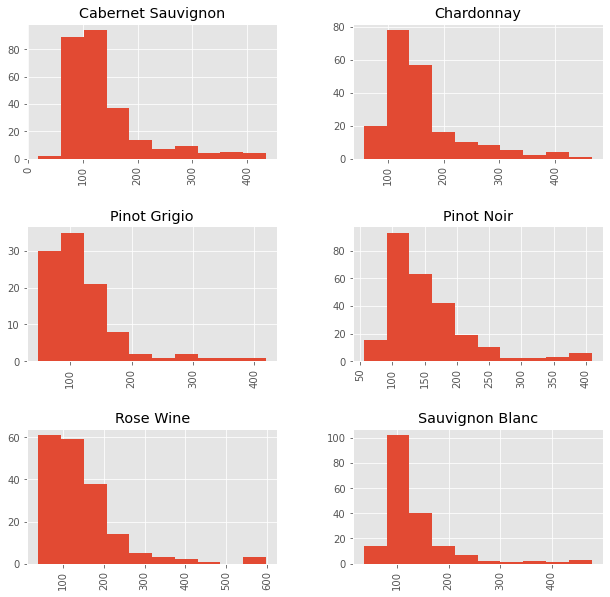

In [16]:
new_final_drizzly_df.hist(figsize=(10,10), column='text_length', by='Category');

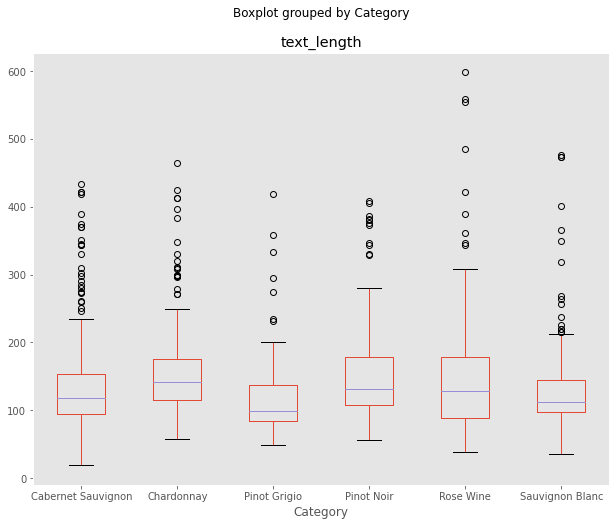

In [17]:
new_final_drizzly_df.boxplot(column='text_length', by='Category', grid=False, figsize=(10,8));

#### We describe the dataframe as it is so we can pull the max and min to show some examples of what the largest and smallest tasting notes look like.

In [18]:
new_final_drizzly_df.text_length.describe()

count    1195.000000
mean      144.646025
std        73.437135
min        19.000000
25%        99.000000
50%       125.000000
75%       166.000000
max       598.000000
Name: text_length, dtype: float64

#### Largest tasting note:

This can show us that even though Cabernet Sauvignon has the most instances in the dataset, it does not have the longest.

In [19]:
new_final_drizzly_df[new_final_drizzly_df.text_length==598].values

array([['Rose Wine',
        'a,Central Coast, United States,Dry,Fruity & Floral,Cheese Blue, Cheese Creamy & Bloomy, Cheese Fresh & Soft, Cheese Hard Aged, Cheese Nutty & Semi-Firm, Cheese Stinky, Chicken, Cured Meats, Dessert Fruit, Dessert Vanilla & Caramel, Duck & Game Bird, Fish Meaty & Oily, Fish White, Fruit Citrus, Fruit Dried, Fruit Sweet, Mushrooms, Nuts, Pasta, Pork, Root Vegetables, Salads & Greens, Shellfish, Tomatoes, Turkey,Acidic, Balanced, Bright, Citrus, Crisp, Crushed Rock, Dried Fruit, Dry, Floral, Fresh, Fruity, Grapefruit, Minerality, Peach, Pumpkin, Red Fruit, Rose Petal, Salty, Smooth, Stone Fruit',
        598]], dtype=object)

#### Smallest tasting note:

In [20]:
new_final_drizzly_df[new_final_drizzly_df.text_length==19]

,Category,Tasting Notes,text_length
19624,Cabernet Sauvignon,"Full,a,a,a,a,Cherry",19


# Data Pre-Processing

In [21]:
# Define a count vectorizer
count_vectorizer = CountVectorizer()
counts = count_vectorizer.fit_transform(new_final_drizzly_df['Tasting Notes'].values)

# Define a tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidfs = tfidf_vectorizer.fit_transform(new_final_drizzly_df['Tasting Notes'].values)

#### Numeric representation of the column "Tasting Notes."

In [22]:
counts

<1195x239 sparse matrix of type '<class 'numpy.int64'>'
	with 22942 stored elements in Compressed Sparse Row format>

#### Showing the result for one row of counts:

In [23]:
counts[0].todense().shape

(1, 239)

In [24]:
for x in counts[0].toarray().tolist():
    print(x)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### List of all words that live in the "Tasting Notes" column.

In [25]:
count_vectorizer.vocabulary_

{'full': 91,
 'napa': 142,
 'valley': 221,
 'united': 219,
 'states': 201,
 'dry': 74,
 'big': 24,
 'bold': 31,
 'beef': 22,
 'duck': 76,
 'game': 94,
 'bird': 25,
 'cherry': 51,
 'dark': 69,
 'fruit': 89,
 'minerality': 135,
 'rose': 181,
 'petal': 163,
 'supple': 206,
 'berry': 23,
 'chocolate': 54,
 'pine': 165,
 'rich': 174,
 'tuscany': 218,
 'italy': 110,
 'herbal': 103,
 'mint': 138,
 'silky': 191,
 'smooth': 194,
 'county': 63,
 'tobacco': 213,
 'toasty': 212,
 'vanilla': 222,
 'cheese': 50,
 'blue': 29,
 'hard': 102,
 'aged': 4,
 'lamb': 113,
 'balanced': 17,
 'blueberry': 30,
 'bright': 35,
 'cassis': 45,
 'earthy': 77,
 'mocha': 139,
 'spicy': 200,
 'central': 47,
 'coast': 57,
 'mushrooms': 141,
 'anise': 9,
 'floral': 85,
 'cinnamon': 55,
 'oak': 151,
 'pepper': 162,
 'velvety': 225,
 'north': 147,
 'savory': 187,
 'chicken': 52,
 'pork': 167,
 'shellfish': 189,
 'citrus': 56,
 'honey': 104,
 'peach': 160,
 'pear': 161,
 'stone': 204,
 'creamy': 64,
 'bloomy': 28,
 'fresh':

# Classifying Categories

#### Using a naive bayes classifer to fit the tfidfs result of the "Tasting Notes" column with the "Category" column in the dataset.

In [26]:
X = tfidfs
y = new_final_drizzly_df['Category'].values

classifier = MultinomialNB()
classifier.fit(X, y)

MultinomialNB()

#### Converting our Tasting Notes column to a list so we can use every instance as examples to train our model.

In [27]:
examples = new_final_drizzly_df['Tasting Notes'].tolist()
examples

['Full,Napa Valley, United States,Dry,Big & Bold,Beef, Duck & Game Bird,Cherry, Dark Fruit, Minerality, Rose Petal, Supple',
 'Full,Napa Valley, United States,Dry,Big & Bold,Beef, Duck & Game Bird,Berry, Chocolate, Pine, Rich',
 'Full,Tuscany, Italy,Dry,Big & Bold,Beef, Duck & Game Bird,Chocolate, Dark Fruit, Herbal, Mint, Silky, Smooth',
 'Full,Napa County, United States,Dry,Big & Bold,Beef, Duck & Game Bird,Chocolate, Dark Fruit, Rich, Tobacco',
 'Full,Napa Valley, United States,Dry,Big & Bold,Beef, Duck & Game Bird,Cherry, Dark Fruit, Minerality, Toasty, Vanilla',
 'Full,Napa Valley, United States,Dry,Big & Bold,Beef, Cheese Blue, Cheese Hard Aged, Duck & Game Bird, Lamb,Balanced, Berry, Blueberry, Bold, Bright, Cassis, Dark Fruit, Earthy, Minerality, Mocha, Spicy',
 'Full,Central Coast, United States,Dry,Big & Bold,Beef, Mushrooms,Anise, Berry, Dark Fruit, Floral, Minerality, Spicy',
 'Full,Napa Valley, United States,Dry,Big & Bold,Beef, Duck & Game Bird,Balanced, Cassis, Chocolate

#### Entering the "Tasting Notes" column into our classifier and seeing what it predicts for each value.

In [28]:
example_counts = tfidf_vectorizer.transform(examples)
predictions = classifier.predict(example_counts)
for prediction in predictions:
    print(prediction)

Cabernet Sauvignon
Cabernet Sauvignon
Cabernet Sauvignon
Cabernet Sauvignon
Cabernet Sauvignon
Cabernet Sauvignon
Cabernet Sauvignon
Cabernet Sauvignon
Chardonnay
Cabernet Sauvignon
Pinot Noir
Cabernet Sauvignon
Cabernet Sauvignon
Pinot Noir
Cabernet Sauvignon
Chardonnay
Cabernet Sauvignon
Cabernet Sauvignon
Cabernet Sauvignon
Cabernet Sauvignon
Cabernet Sauvignon
Pinot Noir
Cabernet Sauvignon
Cabernet Sauvignon
Pinot Noir
Pinot Noir
Chardonnay
Pinot Noir
Pinot Noir
Cabernet Sauvignon
Cabernet Sauvignon
Cabernet Sauvignon
Cabernet Sauvignon
Chardonnay
Cabernet Sauvignon
Cabernet Sauvignon
Pinot Noir
Cabernet Sauvignon
Cabernet Sauvignon
Pinot Noir
Cabernet Sauvignon
Pinot Noir
Pinot Noir
Pinot Noir
Pinot Noir
Pinot Noir
Cabernet Sauvignon
Pinot Noir
Rose Wine
Cabernet Sauvignon
Cabernet Sauvignon
Cabernet Sauvignon
Cabernet Sauvignon
Pinot Noir
Cabernet Sauvignon
Pinot Noir
Pinot Noir
Cabernet Sauvignon
Chardonnay
Pinot Noir
Pinot Noir
Pinot Noir
Pinot Noir
Cabernet Sauvignon
Cabernet 

# Pipelining

In [29]:
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer()),
    ('classifier',  MultinomialNB()) ])

pipeline.fit(new_final_drizzly_df['Tasting Notes'].values, new_final_drizzly_df['Category'].values)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', MultinomialNB())])

In [30]:
pipeline.predict(examples)

array(['Cabernet Sauvignon', 'Cabernet Sauvignon', 'Cabernet Sauvignon',
       ..., 'Rose Wine', 'Rose Wine', 'Sauvignon Blanc'], dtype='<U18')

#### Pipline has the same result and is what we used to create our model that swagger and docker access. We are only keeping the other version in here just as validation that either way, we get the same resulting predictions.

In [31]:
from joblib import dump, load

In [32]:
dump(pipeline, 'filename3.joblib')

['filename3.joblib']

In [33]:
clf = load('filename3.joblib')

In [34]:
example = ["Cherry, Full"]
# Classify that instance using our previously loaded model
clf.predict(example)

array(['Cabernet Sauvignon'], dtype='<U18')

# Cross Validation

In [35]:
k_fold = KFold(n_splits=5)
scores = []
y_true = []
y_pred = []
probas = []
confusion = []

In [36]:
for train_indices, test_indices in k_fold.split(counts):
    train_text = new_final_drizzly_df.iloc[train_indices]['Tasting Notes'].values
    train_y = new_final_drizzly_df.iloc[train_indices]['Category'].values

    test_text = new_final_drizzly_df.iloc[test_indices]['Tasting Notes'].values
    test_y = new_final_drizzly_df.iloc[test_indices]['Category'].values

    pipeline.fit(train_text, train_y)
    predictions = pipeline.predict(test_text)
    prediction_probas = pipeline.predict_proba(test_text)
    
    confusion.append(confusion_matrix(test_y, predictions))
    
    score = accuracy_score(test_y, predictions)
    scores.append(score)
    
    y_true.extend(test_y)
    y_pred.extend(predictions.tolist())
    probas.extend(prediction_probas[:, 1].tolist())

In [37]:
print('Total wines classified:', len(new_final_drizzly_df))
print('Accuracy:', sum(scores)/len(scores))
print('Confusion matrix:')
print(confusion)

Total wines classified: 1195
Accuracy: 0.9188284518828451
Confusion matrix:
[array([[80,  0,  0,  0,  0,  0],
       [ 0, 37,  0,  0,  1,  0],
       [ 0,  0,  1,  0,  0,  1],
       [ 6,  0,  0, 90,  0,  1],
       [ 0,  1,  0,  1,  5,  1],
       [ 0,  0,  0,  0,  0, 14]]), array([[59,  0,  0,  1,  0,  0],
       [ 0, 42,  0,  1,  1,  1],
       [ 0,  0,  9,  0,  0,  3],
       [ 2,  0,  0, 62,  0,  0],
       [ 1,  2,  1,  0, 25,  2],
       [ 0,  1,  1,  0,  0, 25]]), array([[46,  0,  0,  1,  1,  0],
       [ 0, 40,  2,  0,  1,  1],
       [ 0,  2,  8,  0,  1,  4],
       [ 1,  0,  0, 37,  0,  0],
       [ 0,  2,  4,  0, 40,  5],
       [ 0,  3,  1,  0,  2, 37]]), array([[50,  0,  0,  2,  0,  0],
       [ 1, 35,  0,  0,  0,  1],
       [ 0,  1, 18,  0,  1,  2],
       [ 0,  0,  0, 24,  0,  0],
       [ 0,  1,  0,  0, 44,  1],
       [ 0,  0,  2,  0,  1, 55]]), array([[25,  0,  0,  0,  0,  0],
       [ 0, 34,  1,  0,  1,  1],
       [ 0,  2, 39,  0,  3,  7],
       [ 2,  0,  0, 30, 

In [38]:
print(classification_report(y_true, y_pred))

                    precision    recall  f1-score   support

Cabernet Sauvignon       0.95      0.98      0.97       265
        Chardonnay       0.92      0.94      0.93       201
      Pinot Grigio       0.82      0.74      0.78       102
        Pinot Noir       0.98      0.95      0.96       255
         Rose Wine       0.92      0.87      0.89       186
   Sauvignon Blanc       0.85      0.92      0.88       186

          accuracy                           0.92      1195
         macro avg       0.91      0.90      0.90      1195
      weighted avg       0.92      0.92      0.92      1195



# ROC Curve

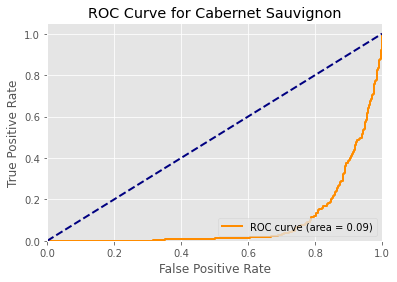

In [41]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_true, probas, pos_label='Cabernet Sauvignon')
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Cabernet Sauvignon')
plt.legend(loc="lower right")
plt.show()

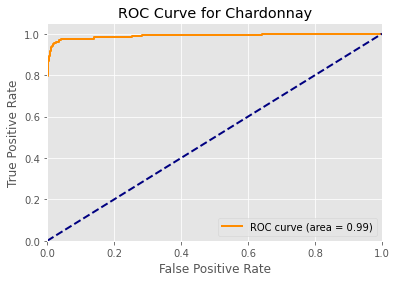

In [44]:
fpr, tpr, _ = roc_curve(y_true, probas, pos_label='Chardonnay')
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Chardonnay')
plt.legend(loc="lower right")
plt.show()

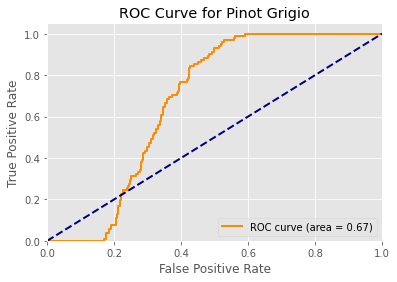

In [43]:
fpr, tpr, _ = roc_curve(y_true, probas, pos_label='Pinot Grigio')
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Pinot Grigio')
plt.legend(loc="lower right")
plt.show()

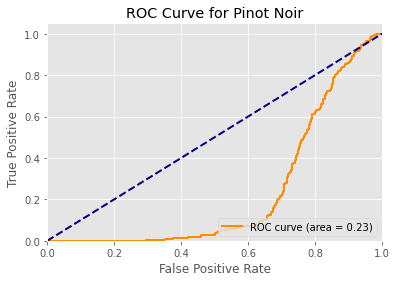

In [45]:
fpr, tpr, _ = roc_curve(y_true, probas, pos_label='Pinot Noir')
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Pinot Noir')
plt.legend(loc="lower right")
plt.show()

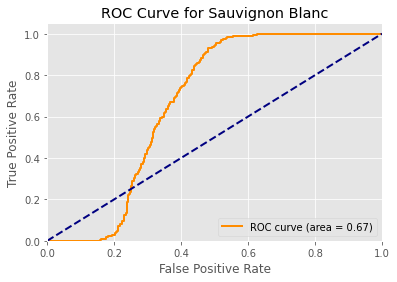

In [46]:
fpr, tpr, _ = roc_curve(y_true, probas, pos_label='Sauvignon Blanc')
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Sauvignon Blanc')
plt.legend(loc="lower right")
plt.show()

# PR Curve

In [50]:
precision, recall, _ = precision_recall_curve(y_true, probas, pos_label='Cabernet Sauvignon')

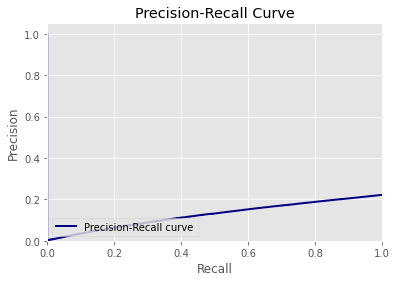

In [51]:
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [52]:
precision, recall, _ = precision_recall_curve(y_true, probas, pos_label='Chardonnay')

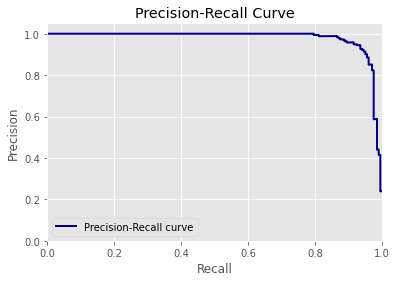

In [53]:
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [54]:
precision, recall, _ = precision_recall_curve(y_true, probas, pos_label='Pinot Grigio')

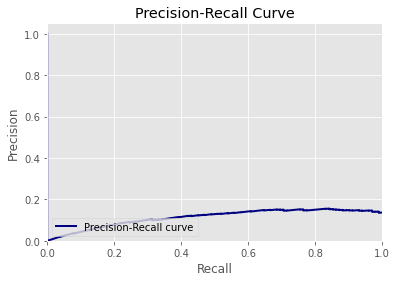

In [55]:
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [56]:
precision, recall, _ = precision_recall_curve(y_true, probas, pos_label='Pinot Noir')

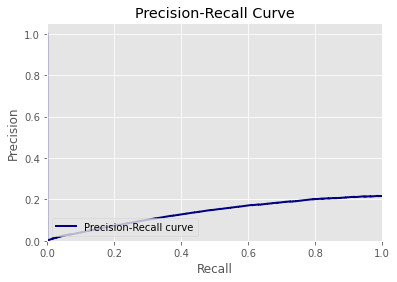

In [57]:
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [58]:
precision, recall, _ = precision_recall_curve(y_true, probas, pos_label='Sauvignon Blanc')

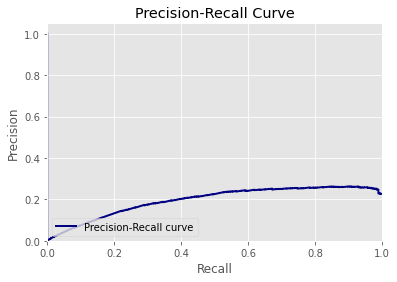

In [59]:
plt.clf()
plt.plot(recall, precision, lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Learning Curve

In [60]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

CPU times: user 1.01 s, sys: 145 ms, total: 1.15 s
Wall time: 2.86 s


<module 'matplotlib.pyplot' from '/Users/arealjones/opt/anaconda3/envs/test_env/lib/python3.6/site-packages/matplotlib/pyplot.py'>

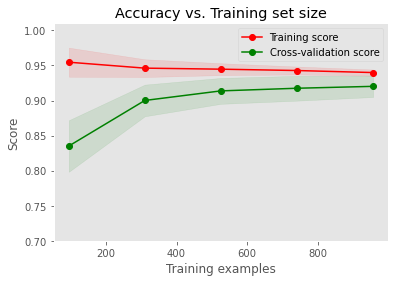

In [61]:
y = new_final_drizzly_df['Category'].values
X = tfidf_vectorizer.fit_transform(new_final_drizzly_df['Tasting Notes'].values)

cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
%time plot_learning_curve(MultinomialNB(), "Accuracy vs. Training set size", counts, y, ylim=(0.7, 1.01), cv=cv, n_jobs=4);